<a href="https://colab.research.google.com/github/Slimlav/Netology/blob/main/%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D0%BE%D0%B9_%D1%81%D0%B5%D1%82%D0%B8_%D0%BD%D0%B0_%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Классификация изображений: Cats vs Dogs**

In [1]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import vgg16
import zipfile
%matplotlib inline
from matplotlib import pyplot as plt
import re
import os
from random import shuffle
from glob import glob
from sklearn.metrics import log_loss
from keras.optimizers import RMSprop

print(tf.__version__)
print(tf.executing_eagerly())

2.9.2
True


**Функции загрузки данных**

In [2]:
!wget -O dogs-vs-cats.zip "https://www.dropbox.com/s/rxs0lxfauujpgih/dogs-vs-cats.zip?dl=1"

--2022-10-18 12:50:43--  https://www.dropbox.com/s/rxs0lxfauujpgih/dogs-vs-cats.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/rxs0lxfauujpgih/dogs-vs-cats.zip [following]
--2022-10-18 12:50:43--  https://www.dropbox.com/s/dl/rxs0lxfauujpgih/dogs-vs-cats.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucad4317a2563b25bc3beac90242.dl.dropboxusercontent.com/cd/0/get/BvCYBcckX0-u8qMfTYJw9FiIxkSfT7cGNZfRwvqgxWjydTLcrg6Y7Kcx_0rljFtE1ueNlz0xm_G1sQrxigbSAHRhduh64_obCXuZY9FuMP4YTTvXrx4-dzvoyeA4cnb7NiKuF5RFaEreHXWwxc4l77nb_Lhn6c2OxO1m5TzlUAcalA/file?dl=1# [following]
--2022-10-18 12:50:44--  https://ucad4317a2563b25bc3beac90242.dl.dropboxusercontent.com/cd/0/get/BvCYBcckX0-u8qMfTYJw9FiIxkSfT7cGNZfRwvqgxWjydTLcrg6Y7Kcx_0rljFt

In [3]:
!unzip dogs-vs-cats.zip
!unzip train.zip
!unzip test1.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/5

In [4]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('train/*.jpg')
test_files = glob('test1/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=100):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])


**Визуализируем примеры для обучения**

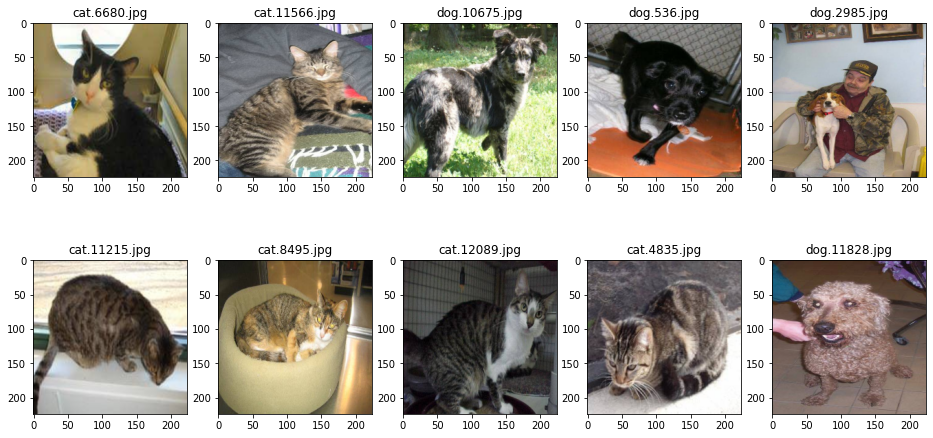

In [5]:
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

**Загружаем предобученную модель**

In [6]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

58889256/58889256 [==============================] - 0s 0us/step


In [7]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

**Добавляем полносвязный слой**

In [10]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

**Выводим архитектуру модели**

In [11]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

**Компилируем модель и запускаем обучение**

In [12]:
optimizer = RMSprop(learning_rate=1e-5)
model.compile(optimizer=optimizer, 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [13]:
val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=200,  # число вызовов генератора за эпоху
          epochs=25,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/25
200/200 [==============================] - 129s 562ms/step - loss: 0.2968 - accuracy: 0.8681 - val_loss: 0.2137 - val_accuracy: 1.0000
Epoch 2/25
200/200 [==============================] - 111s 556ms/step - loss: 0.1378 - accuracy: 0.9507 - val_loss: 0.1219 - val_accuracy: 1.0000
Epoch 3/25
200/200 [==============================] - 110s 549ms/step - loss: 0.0881 - accuracy: 0.9726 - val_loss: 0.1187 - val_accuracy: 1.0000
Epoch 4/25
200/200 [==============================] - 110s 549ms/step - loss: 0.0612 - accuracy: 0.9850 - val_loss: 0.1191 - val_accuracy: 1.0000
Epoch 5/25
200/200 [==============================] - 109s 547ms/step - loss: 0.0432 - accuracy: 0.9912 - val_loss: 0.1485 - val_accuracy: 1.0000
Epoch 6/25
200/200 [==============================] - 110s 550ms/step - loss: 0.0295 - accuracy: 0.9966 - val_loss: 0.0908 - val_accuracy: 1.0000
Epoch 7/25
200/200 [==============================] - 109s 545ms/step - loss: 0.0223 - accuracy: 0.9979 - val_loss: 0.0823 -

In [14]:
model.save('cats-dogs-vgg16.hdf5')

**Предсказания на проверочной выборке**

In [15]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

12500/12500 [==============================] - 110s 9ms/step


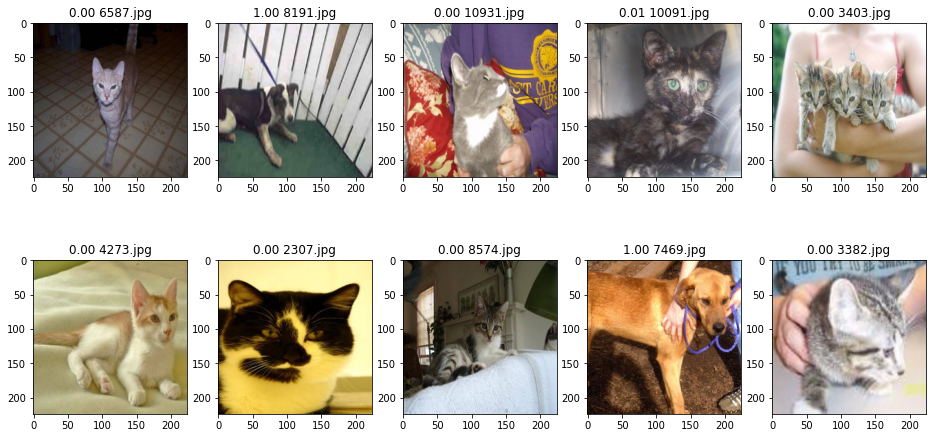

In [16]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

**Готовим данные для отправки**

In [19]:
with open('submit.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

In [20]:
!head submit.csv

id,label
6587,0.002765
8191,0.998591
10931,0.004039
10091,0.005891
3403,0.000172
4273,0.000310
2307,0.000000
8574,0.000001
7469,0.999508
